In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string


In [2]:
# generate dataset
def generate_dataset(rows=1000, cols=9):
    np.random.seed(42)
    data = {
        'title': [f"Title {i}" for i in range(rows)],
        'text': [f"Text content {i}" for i in range(rows)],
        'source': np.random.choice(['CNN', 'BBC', 'Fox', 'FakeNews'], rows),
        'author': np.random.choice(['Author A', 'Author B', 'Unknown'], rows),
        'likes': np.random.randint(0, 1000, rows),
        'shares': np.random.randint(0, 500, rows),
        'comments': np.random.randint(0, 200, rows),
        'label': np.random.choice(['Real', 'Fake'], rows),
        'timestamp': pd.date_range(start='1/1/2023', periods=rows, freq='H')
    }
    return pd.DataFrame(data)

# save dataset to a CSV file
def save_dataset_to_csv(df, file_name='dataset.csv'):
    """
    Save the generated dataset to a CSV file.

    Parameters:
        df (pd.DataFrame): The dataset to save.
        file_name (str): The name of the CSV file to save the dataset to.
    """
    df.to_csv(file_name, index=False)
    print(f"Dataset saved to {file_name}")

# Create a dataset
df = generate_dataset()
print(df.head())

# Save the dataset to a CSV file
save_dataset_to_csv(df, file_name='fake_news_dataset.csv')

     title            text    source    author  likes  shares  comments label  \
0  Title 0  Text content 0       Fox  Author B    795     499       175  Fake   
1  Title 1  Text content 1  FakeNews   Unknown    964     225       127  Real   
2  Title 2  Text content 2       CNN  Author A    972     141       149  Fake   
3  Title 3  Text content 3       Fox  Author A    592     291        16  Fake   
4  Title 4  Text content 4       Fox  Author A    113     480        68  Real   

            timestamp  
0 2023-01-01 00:00:00  
1 2023-01-01 01:00:00  
2 2023-01-01 02:00:00  
3 2023-01-01 03:00:00  
4 2023-01-01 04:00:00  
Dataset saved to fake_news_dataset.csv


<ipython-input-2-8772ec6d2448>:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.date_range(start='1/1/2023', periods=rows, freq='H')


In [3]:
print(df.tail())

         title              text    source    author  likes  shares  comments  \
995  Title 995  Text content 995       CNN  Author B    799     337        15   
996  Title 996  Text content 996       CNN  Author B    160     313        67   
997  Title 997  Text content 997  FakeNews  Author B    783      74        98   
998  Title 998  Text content 998  FakeNews  Author A    459     440        47   
999  Title 999  Text content 999       Fox  Author A    549     278       183   

    label           timestamp  
995  Fake 2023-02-11 11:00:00  
996  Real 2023-02-11 12:00:00  
997  Fake 2023-02-11 13:00:00  
998  Fake 2023-02-11 14:00:00  
999  Fake 2023-02-11 15:00:00  


In [4]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

print("Missing values after handling:\n", df.isnull().sum())

Missing values:
 title        0
text         0
source       0
author       0
likes        0
shares       0
comments     0
label        0
timestamp    0
dtype: int64
Missing values after handling:
 title        0
text         0
source       0
author       0
likes        0
shares       0
comments     0
label        0
timestamp    0
dtype: int64


In [5]:
# Remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]
    return df

# Remove outliers from 'likes' and 'shares'
df = remove_outliers(df, 'likes')
df = remove_outliers(df, 'shares')

print("Shape after removing outliers:", df.shape)

Shape after removing outliers: (1000, 9)


In [6]:
# Encode the target variable
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
print(df['label'].head())

0    0
1    1
2    0
3    0
4    1
Name: label, dtype: int64


In [7]:
# Split the data into training and testing sets
X = df[['text', 'likes', 'shares', 'comments']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (800, 4)
Testing data shape: (200, 4)


In [8]:
# Use TF-IDF for text feature extraction
tfidf = TfidfVectorizer(max_features=500)
X_train_tfidf = tfidf.fit_transform(X_train['text'])
X_test_tfidf = tfidf.transform(X_test['text'])

# Combine text features with numerical features
X_train_numerical = X_train[['likes', 'shares', 'comments']].values
X_test_numerical = X_test[['likes', 'shares', 'comments']].values

X_train_combined = np.hstack((X_train_tfidf.toarray(), X_train_numerical))
X_test_combined = np.hstack((X_test_tfidf.toarray(), X_test_numerical))

In [9]:
# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

In [10]:
# Train the KNN model
knn.fit(X_train_combined, y_train)

KNeighborsClassifier()

In [11]:
# Make predictions
y_pred = knn.predict(X_test_combined)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.495
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.45      0.45        91
           1       0.54      0.53      0.53       109

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.50      0.49      0.50       200



In [12]:
# GridSearchCV for hyperparameter tuning
param_grid = {'n_neighbors': [3, 5, 7, 9]}
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_combined, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'n_neighbors': 7}
Best score: 0.4925


In [13]:
# Use the best model to make predictions
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_combined)

# Calculate accuracy for the best model
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy of the best model:", accuracy_best)

Accuracy of the best model: 0.465


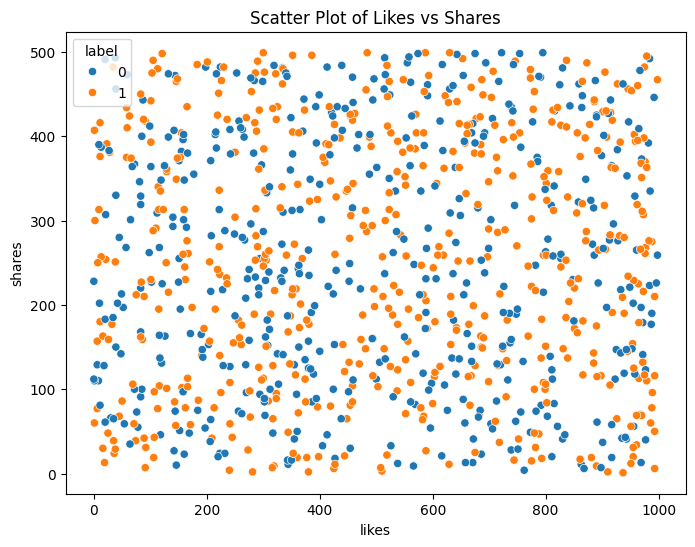

In [14]:
# Scatter plot of 'likes' vs 'shares'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='likes', y='shares', hue='label', data=df)
plt.title("Scatter Plot of Likes vs Shares")
plt.show()

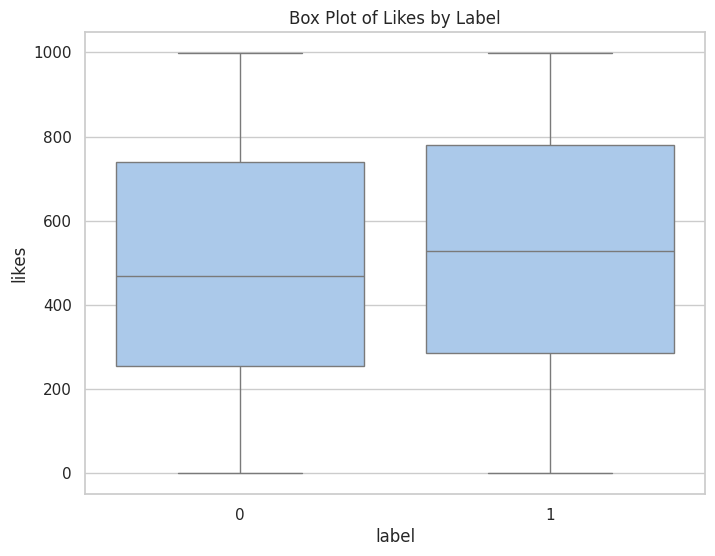

In [16]:
# Box plot of 'likes' by label
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='likes', data=df)
plt.title("Box Plot of Likes by Label")
plt.show()

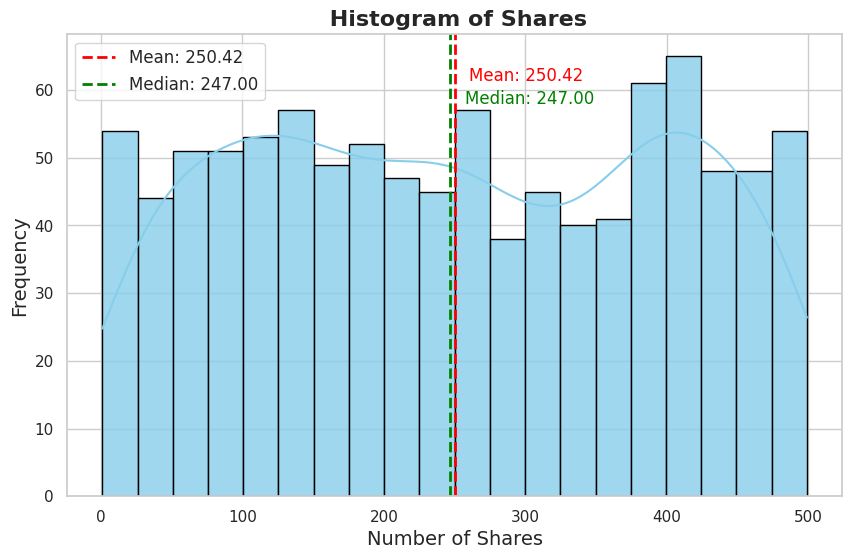

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the style for the plot
sns.set(style="whitegrid", palette="pastel")

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot the histogram with density curve
sns.histplot(df['shares'], bins=20, kde=True, color='skyblue', edgecolor='black', alpha=0.8)

# Add a vertical line for the mean
mean_shares = df['shares'].mean()
plt.axvline(mean_shares, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_shares:.2f}')

# Add a vertical line for the median
median_shares = df['shares'].median()
plt.axvline(median_shares, color='green', linestyle='--', linewidth=2, label=f'Median: {median_shares:.2f}')

# Add annotations for mean and median
plt.text(mean_shares + 10, plt.ylim()[1] * 0.9, f'Mean: {mean_shares:.2f}', color='red', fontsize=12)
plt.text(median_shares + 10, plt.ylim()[1] * 0.85, f'Median: {median_shares:.2f}', color='green', fontsize=12)

# Add title and labels
plt.title(" Histogram of Shares", fontsize=16, fontweight='bold')
plt.xlabel("Number of Shares", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Add a legend
plt.legend(fontsize=12)

# Show the plot
plt.show()

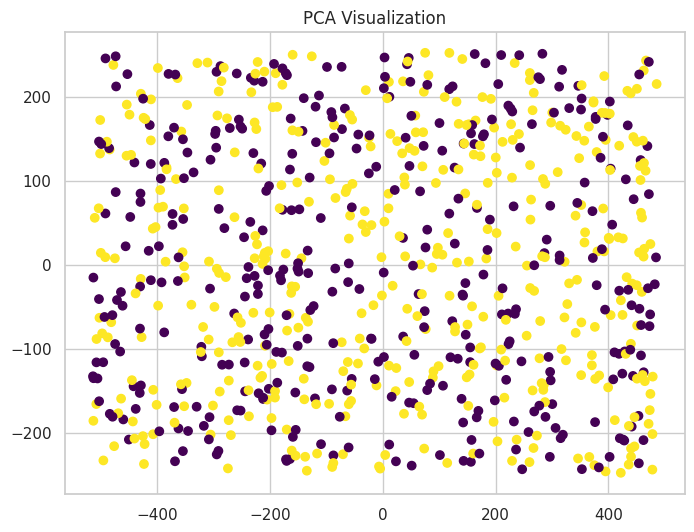

In [18]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_combined)

# Plot PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis')
plt.title("PCA Visualization")
plt.show()

In [19]:
import joblib

# Save the best model
joblib.dump(best_knn, 'fake_news_detector.pkl')
print("Model saved as 'fake_news_detector.pkl'")

Model saved as 'fake_news_detector.pkl'


In [20]:
# Load the saved model
loaded_model = joblib.load('fake_news_detector.pkl')


# Test the loaded model
y_pred_loaded = loaded_model.predict(X_test_combined)
print("Accuracy of the loaded model:", accuracy_score(y_test, y_pred_loaded))

Accuracy of the loaded model: 0.465


In [25]:
# Example prediction
new_data = pd.DataFrame({
    'text': ["This is a fake news article"],
    'likes': [10],
    'shares': [5],
    'comments': [2]
})

# Preprocess the new data
new_data_tfidf = tfidf.transform(new_data['text'])
new_data_numerical = new_data[['likes', 'shares', 'comments']].values
new_data_combined = np.hstack((new_data_tfidf.toarray(), new_data_numerical))

# Predict using the loaded model
prediction = loaded_model.predict(new_data_combined)
print("Prediction:", "Fake" if prediction[0] == 1 else "Real")

Prediction: Fake
